# Assignment 2: Anime Recommendation Analysis

## Dataset: Anime Recommendations Database

This notebook contains the analysis for anime rating prediction and classification using machine learning.


---

# Section 1: Identify the Predictive Task

## Task 1: Regression - Predicting Anime Rating

Predict the rating of an anime (continuous value from 1-10).

- Input: Anime features (genre, type, episodes, members)
- Output: Rating (continuous value, typically 1-10)
- Problem Type: Supervised regression
- Dataset: Samples with valid ratings

## Task 2: Binary Classification - Predicting Anime Type (TV vs Movie)

Predict whether an anime is a TV series or Movie (binary classification).

- Input: Same anime features as Task 1
- Output: Binary label (TV = 0, Movie = 1, or other binary split)
- Problem Type: Supervised binary classification
- Dataset: Samples with valid type labels


## How We Will Evaluate Our Models

### Task 1 (Regression - Rating Prediction):

- **RMSE (Root Mean Squared Error):** Primary metric for regression
- **R² Score:** Proportion of variance explained (0 = baseline, 1 = perfect)
- **MAE (Mean Absolute Error):** Average prediction error

**Evaluation Protocol:**
- 80/20 train/test split
- 5-fold cross-validation for model selection
- Report RMSE, R², and MAE on test set

### Task 2 (Binary Classification - Type Prediction):

- **Accuracy:** Overall correctness
- **Precision:** Of predicted positives, how many are correct
- **Recall:** Of actual positives, how many were caught
- **F1-Score:** Balances precision and recall
- **ROC-AUC:** Model discrimination across thresholds (0.5 = random, 1.0 = perfect)

**Evaluation Protocol:**
- 80/20 stratified train/test split
- 5-fold stratified cross-validation for model selection
- Report all metrics (Accuracy, Precision, Recall, F1, ROC-AUC)


## Relevant Baselines for Comparison

### Task 1 (Regression - Rating Prediction):

**Baseline 1: Mean Rating Predictor**
- Always predicts the mean rating
- Expected: R² = 0, baseline RMSE

**Baseline 2: Linear Regression (No Regularization)** - **MAIN BASELINE**
- Linear Regression without regularization
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance before adding regularization

**Comparison:** Our models (Linear Regression with L1/L2 regularization - Lasso/Ridge) should outperform this baseline, demonstrating regularization benefits.

### Task 2 (Binary Classification - Type Prediction):

**Baseline 1: Random Classifier**
- Randomly predicts TV or Movie (50/50)
- Expected: ~50% accuracy, ROC-AUC ~0.50

**Baseline 2: Majority Class Classifier**
- Always predicts most common type
- Expected: Accuracy = proportion of majority class

**Baseline 3: Logistic Regression (No Regularization)** - **MAIN BASELINE**
- Logistic Regression without regularization (C=1.0)
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance before adding regularization

**Comparison:** Our models (Logistic Regression with L1/L2 regularization) should outperform this baseline.


## How We Will Assess Prediction Validity

We use validation strategies to ensure predictions are reliable and generalizable:

1. **Train/Test Split with Stratification**
   - **Task 1:** 80/20 split (standard split for regression)
   - **Task 2:** 80/20 split, stratified by type (maintains class distribution)
   - Purpose: Evaluate on unseen data, prevent overfitting

2. **Cross-Validation for Model Selection**
   - 5-fold cross-validation on training set
   - Purpose: Select best hyperparameters (alpha values for Lasso/Ridge, C values for Logistic Regression)
   - Use: Compare models, regularization strengths, feature combinations

3. **Residual Analysis** (Task 1 only)
   - Plot residuals vs predicted values
   - Check for patterns indicating model misspecification

4. **Confusion Matrix Analysis** (Task 2 only)
   - Analyze TP, TN, FP, FN
   - Identify if model is too conservative or aggressive

5. **Learning Curves**
   - Plot training vs validation performance
   - Detect overfitting (large gap) or underfitting (both low)

6. **Feature Importance Analysis**
   - Analyze coefficients (linear/logistic regression) or feature importances (tree-based models)
   - Validate features align with domain knowledge

7. **ROC Curve Analysis** (Task 2 only)
   - Plot TPR vs FPR across all thresholds
   - Compare models and select optimal threshold

8. **Performance Stability**
   - Evaluate on multiple random splits
   - Ensure consistent performance

These strategies ensure our models' predictions are reliable, generalizable, and not overfitted.


In [28]:
# Load and clean the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('anime.csv')

# Create a copy for cleaning
df_clean = df.copy()

# Check for duplicate rows
print(f"Number of duplicate rows: {df_clean.duplicated().sum()}")

# Remove rows with missing rating (target for Task 1)
print(f"\nRows with missing rating: {df_clean['rating'].isnull().sum()}")
df_clean = df_clean[df_clean['rating'].notna()].copy()

# Remove rows with missing type (target for Task 2)
print(f"Rows with missing type: {df_clean['type'].isnull().sum()}")
df_clean = df_clean[df_clean['type'].notna()].copy()

print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Rating range: {df_clean['rating'].min():.2f} - {df_clean['rating'].max():.2f}")


Number of duplicate rows: 0

Rows with missing rating: 230
Rows with missing type: 0

Final dataset shape: (12064, 7)
Rating range: 1.67 - 10.00



# Section 2: Exploratory Analysis, Data Collection, Pre-processing, and Discussion

## 2.1 Context: Dataset Source and Collection

### Dataset Source:
- **Dataset:** Anime Recommendations Database
- **Source:** Kaggle (https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)
- **Creator:** Cooper Union

### What is it for:
This dataset contains information about anime series and movies, including ratings, genres, types, and member counts. It was collected for recommendation systems and analysis of anime preferences.

### How was it collected:
The dataset appears to be scraped or collected from anime databases/websites (likely MyAnimeList or similar platforms) where users rate and review anime. The data includes:
- User ratings aggregated per anime
- Metadata about each anime (genre, type, episodes)
- Popularity metrics (member counts)

### Dataset Characteristics:
- **Total samples:** 12,294 anime entries
- **Features:** 7 columns (anime_id, name, genre, type, episodes, rating, members)
- **Time period:** Historical anime data (exact collection date not specified)
- **Coverage:** Various anime types (TV, Movie, OVA, Special, ONA, Music)


## 2.2 Discussion: Data Processing

### Initial Data Quality Assessment:

1. **Missing Values:**
   - Rating: 230 missing (1.87% of data) - removed for Task 1
   - Genre: 62 missing (0.50%) - can be handled via imputation or indicator variables
   - Type: 25 missing (0.20%) - removed for Task 2
   - Episodes: All present but stored as object type (needs conversion)

2. **Data Type Issues:**
   - Episodes column stored as object (string) instead of numeric
   - Some episodes contain "Unknown" values
   - Need to convert to numeric or handle special values

3. **Data Cleaning Steps:**
   - Removed rows with missing ratings (required for Task 1)
   - Removed rows with missing type (required for Task 2)
   - Final cleaned dataset: 12,064 samples
   - No duplicate rows found

### Feature Engineering Considerations:

1. **Genre Feature:**
   - Currently stored as comma-separated strings (e.g., "Action, Adventure, Drama")
   - Need to: split into individual genres, create binary indicators, or use text processing

2. **Episodes Feature:**
   - Contains numeric values and "Unknown" strings
   - Need to: convert to numeric, handle "Unknown" as missing or separate category

3. **Type Feature:**
   - 6 categories: TV, OVA, Movie, Special, ONA, Music
   - For Task 2: Focus on TV vs Movie for binary classification
   - Can use one-hot encoding for multiclass or binary encoding for binary task

4. **Members Feature:**
   - Represents popularity (number of users who added anime to their list)
   - May need log transformation if highly skewed
   - Good predictor for rating (popular anime may have higher ratings)

### Processing Pipeline:
1. Load raw data
2. Remove missing target variables (rating, type)
3. Convert episodes to numeric (handle "Unknown")
4. Process genre (split, encode)
5. Encode categorical features (type)
6. Scale/normalize features as needed


## 2.3 Code: Exploratory Data Analysis

### 2.3.1 Dataset Overview and Statistics


In [29]:
# Detailed dataset statistics
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nTotal samples: {len(df_clean):,}")
print(f"Features: {len(df_clean.columns)}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n" + "="*70)
print("NUMERICAL FEATURES SUMMARY")
print("="*70)
print(df_clean[['rating', 'members', 'episodes']].describe())

print("\n" + "="*70)
print("MISSING VALUES AFTER CLEANING")
print("="*70)
print(df_clean.isnull().sum())
print(f"\nMissing percentage:")
print((df_clean.isnull().sum() / len(df_clean) * 100).round(2))


DATASET OVERVIEW

Total samples: 12,064
Features: 7
Memory usage: 3350.40 KB

NUMERICAL FEATURES SUMMARY
             rating       members
count  12064.000000  1.206400e+04
mean       6.473902  1.827952e+04
std        1.026746  5.527578e+04
min        1.670000  1.200000e+01
25%        5.880000  2.210000e+02
50%        6.570000  1.539000e+03
75%        7.180000  9.485500e+03
max       10.000000  1.013917e+06

MISSING VALUES AFTER CLEANING
anime_id     0
name         0
genre       47
type         0
episodes     0
rating       0
members      0
dtype: int64

Missing percentage:
anime_id    0.00
name        0.00
genre       0.39
type        0.00
episodes    0.00
rating      0.00
members     0.00
dtype: float64


In [30]:
# Convert episodes to numeric (handle "Unknown")
df_clean['episodes'] = pd.to_numeric(df_clean['episodes'], errors='coerce')

print("="*70)
print("EPISODES FEATURE ANALYSIS")
print("="*70)
print(f"Episodes with 'Unknown': {df_clean['episodes'].isnull().sum()}")
print(f"\nEpisodes statistics:")
print(df_clean['episodes'].describe())
print(f"\nEpisodes distribution (top values):")
print(df_clean['episodes'].value_counts().head(10))


EPISODES FEATURE ANALYSIS
Episodes with 'Unknown': 188

Episodes statistics:
count    11876.000000
mean        12.447289
std         47.011062
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64

Episodes distribution (top values):
episodes
1.0     5612
2.0     1075
12.0     812
13.0     571
26.0     514
3.0      505
4.0      327
6.0      266
24.0     180
52.0     177
Name: count, dtype: int64


### 2.3.2 Target Variable Analysis


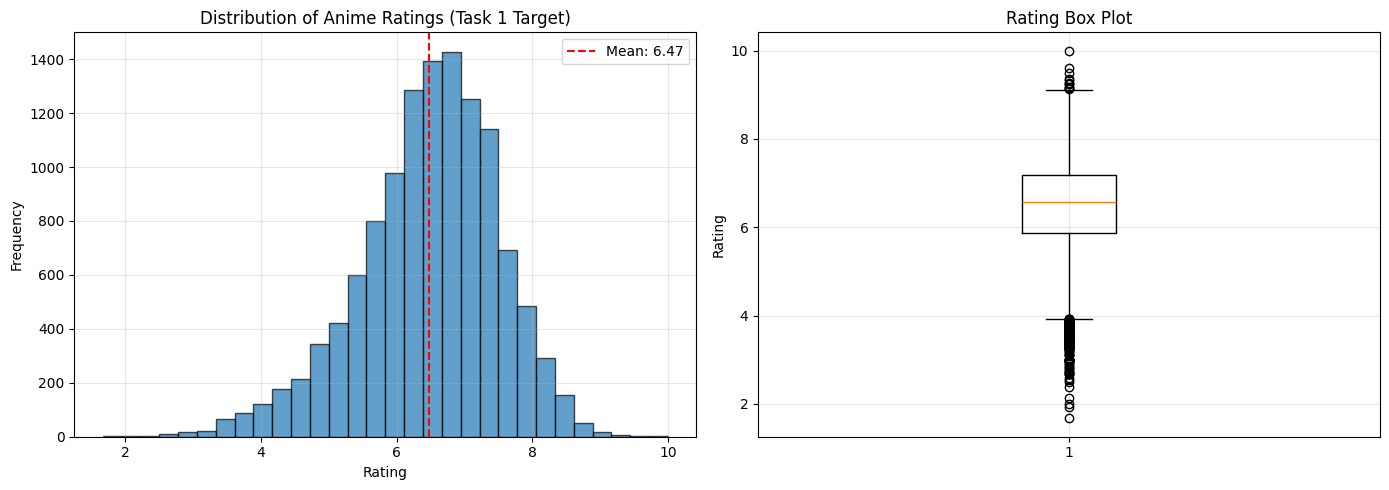

RATING STATISTICS (Task 1 Target)
Mean: 6.47
Median: 6.57
Std Dev: 1.03
Min: 1.67
Max: 10.00
Skewness: -0.54


In [15]:
# Task 1 Target: Rating Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating histogram
axes[0].hist(df_clean['rating'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Anime Ratings (Task 1 Target)')
axes[0].axvline(df_clean['rating'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["rating"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rating box plot
axes[1].boxplot(df_clean['rating'], vert=True)
axes[1].set_ylabel('Rating')
axes[1].set_title('Rating Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("RATING STATISTICS (Task 1 Target)")
print("="*70)
print(f"Mean: {df_clean['rating'].mean():.2f}")
print(f"Median: {df_clean['rating'].median():.2f}")
print(f"Std Dev: {df_clean['rating'].std():.2f}")
print(f"Min: {df_clean['rating'].min():.2f}")
print(f"Max: {df_clean['rating'].max():.2f}")
print(f"Skewness: {df_clean['rating'].skew():.2f}")


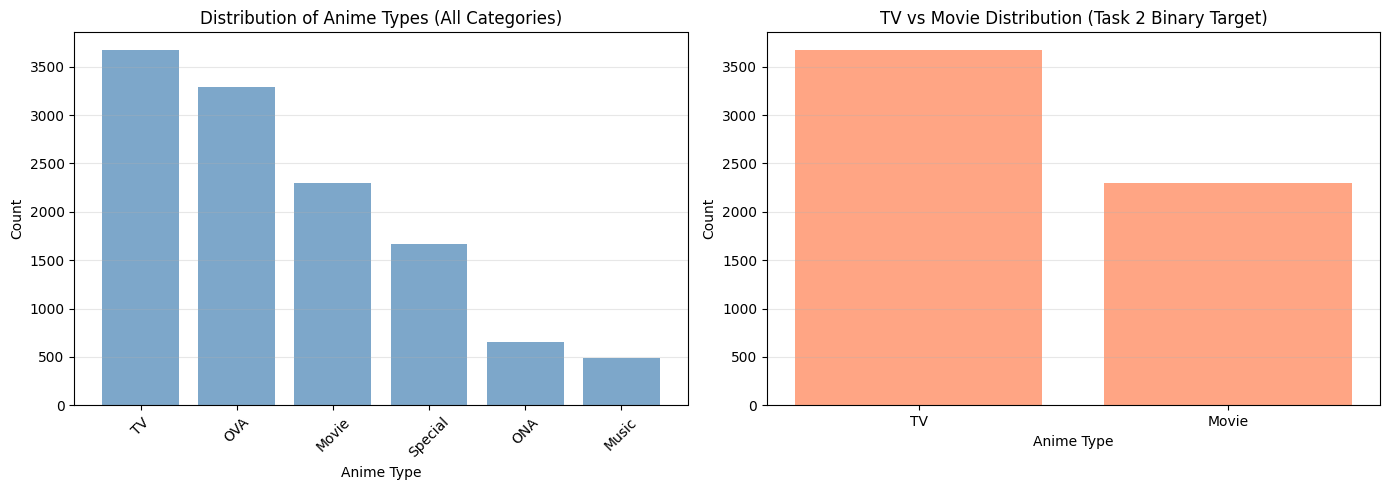

TYPE DISTRIBUTION (Task 2 Target)

All types:
type
TV         3671
OVA        3285
Movie      2297
Special    1671
ONA         652
Music       488
Name: count, dtype: int64

Total: 12064

TV vs Movie (for binary classification):
type
TV       3671
Movie    2297
Name: count, dtype: int64
TV percentage: 61.51%
Movie percentage: 38.49%


In [16]:
# Task 2 Target: Type Distribution
df_task2 = df_clean[df_clean['type'].notna()].copy()
df_task2_binary = df_task2[df_task2['type'].isin(['TV', 'Movie'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All types distribution
type_counts = df_clean['type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Anime Types (All Categories)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# TV vs Movie (for binary classification)
tv_movie_counts = df_task2_binary['type'].value_counts()
axes[1].bar(tv_movie_counts.index, tv_movie_counts.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Count')
axes[1].set_title('TV vs Movie Distribution (Task 2 Binary Target)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("="*70)
print("TYPE DISTRIBUTION (Task 2 Target)")
print("="*70)
print("\nAll types:")
print(df_clean['type'].value_counts())
print(f"\nTotal: {len(df_clean)}")
print("\nTV vs Movie (for binary classification):")
print(df_task2_binary['type'].value_counts())
print(f"TV percentage: {(df_task2_binary['type'] == 'TV').sum() / len(df_task2_binary) * 100:.2f}%")
print(f"Movie percentage: {(df_task2_binary['type'] == 'Movie').sum() / len(df_task2_binary) * 100:.2f}%")


### 2.3.3 Feature Analysis


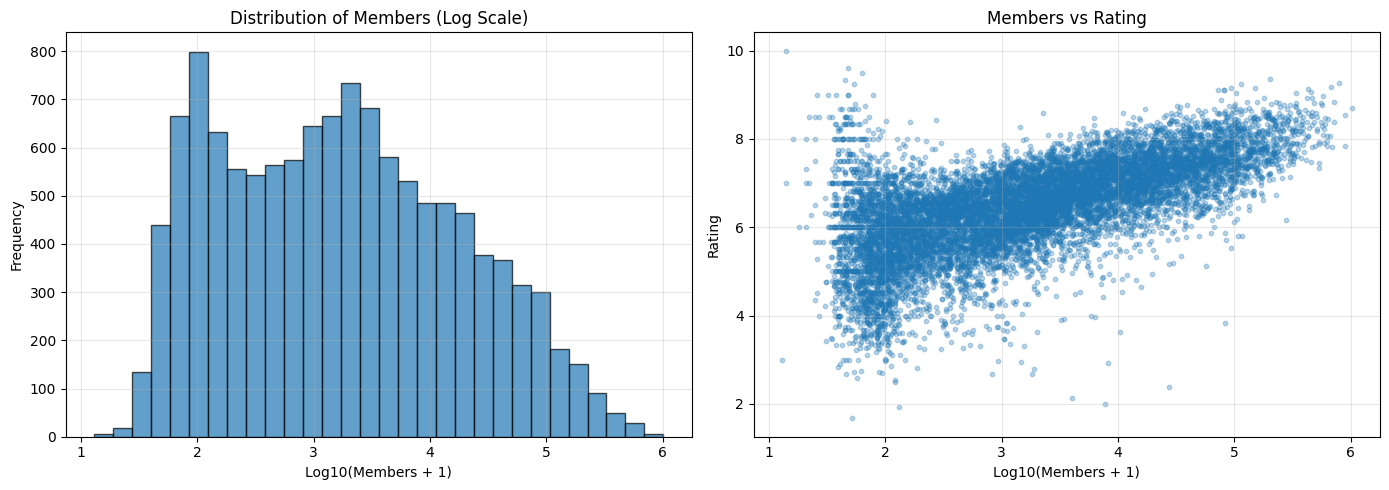

MEMBERS (POPULARITY) STATISTICS
count    1.206400e+04
mean     1.827952e+04
std      5.527578e+04
min      1.200000e+01
25%      2.210000e+02
50%      1.539000e+03
75%      9.485500e+03
max      1.013917e+06
Name: members, dtype: float64

Correlation with rating: 0.3880


In [17]:
# Members (popularity) analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Members distribution (log scale)
axes[0].hist(np.log10(df_clean['members'] + 1), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log10(Members + 1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Members (Log Scale)')
axes[0].grid(True, alpha=0.3)

# Members vs Rating scatter
axes[1].scatter(np.log10(df_clean['members'] + 1), df_clean['rating'], 
                alpha=0.3, s=10)
axes[1].set_xlabel('Log10(Members + 1)')
axes[1].set_ylabel('Rating')
axes[1].set_title('Members vs Rating')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("MEMBERS (POPULARITY) STATISTICS")
print("="*70)
print(df_clean['members'].describe())
print(f"\nCorrelation with rating: {df_clean[['members', 'rating']].corr().iloc[0,1]:.4f}")


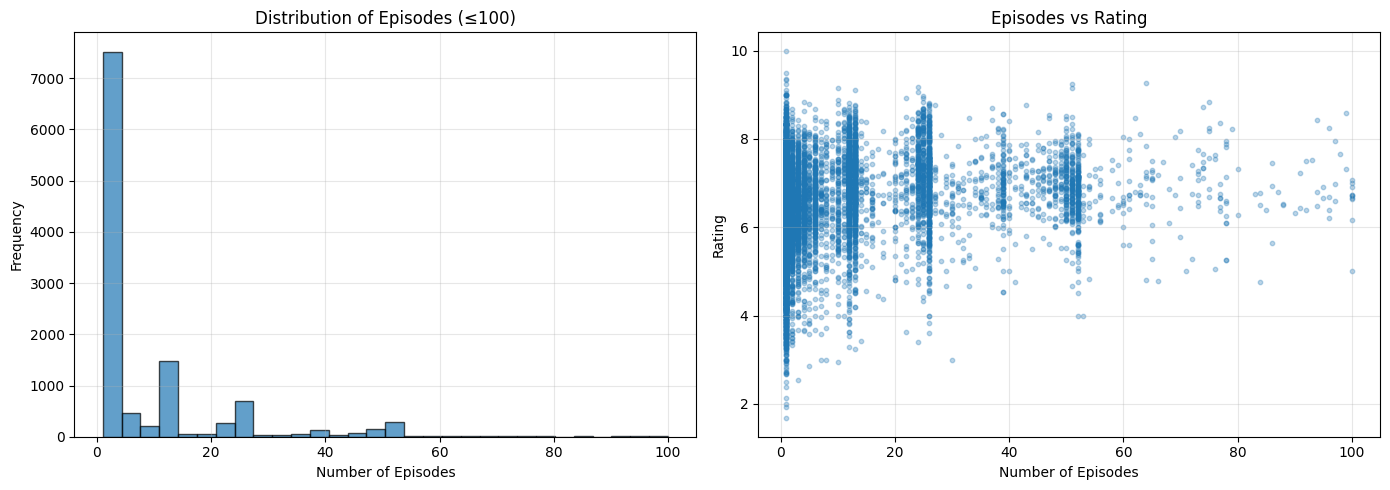

EPISODES STATISTICS
count    11876.000000
mean        12.447289
std         47.011062
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64

Correlation with rating: 0.0888


In [18]:
# Episodes analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Episodes distribution (excluding Unknown)
episodes_clean = df_clean['episodes'].dropna()
axes[0].hist(episodes_clean[episodes_clean <= 100], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Episodes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Episodes (≤100)')
axes[0].grid(True, alpha=0.3)

# Episodes vs Rating
axes[1].scatter(episodes_clean[episodes_clean <= 100], 
                df_clean.loc[episodes_clean[episodes_clean <= 100].index, 'rating'],
                alpha=0.3, s=10)
axes[1].set_xlabel('Number of Episodes')
axes[1].set_ylabel('Rating')
axes[1].set_title('Episodes vs Rating')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("EPISODES STATISTICS")
print("="*70)
print(episodes_clean.describe())
print(f"\nCorrelation with rating: {df_clean[['episodes', 'rating']].corr().iloc[0,1]:.4f}")


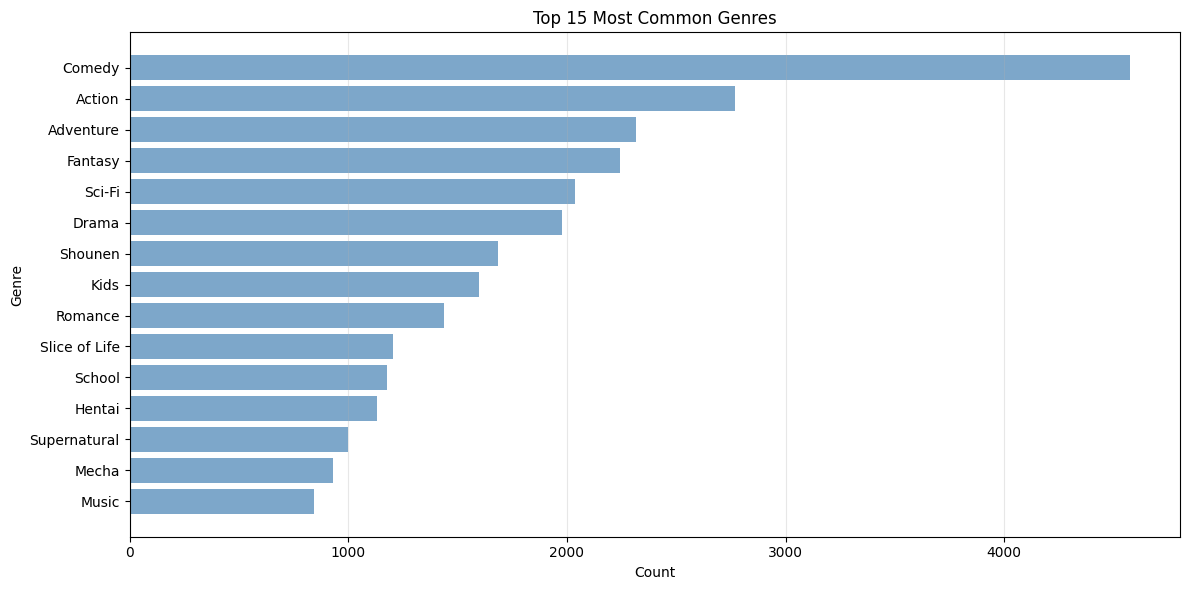

TOP 15 GENRES
Comedy                        :  4575 (37.92%)
Action                        :  2768 (22.94%)
Adventure                     :  2316 (19.20%)
Fantasy                       :  2242 (18.58%)
Sci-Fi                        :  2036 (16.88%)
Drama                         :  1977 (16.39%)
Shounen                       :  1684 (13.96%)
Kids                          :  1598 (13.25%)
Romance                       :  1437 (11.91%)
Slice of Life                 :  1204 (9.98%)
School                        :  1176 (9.75%)
Hentai                        :  1133 (9.39%)
Supernatural                  :  1001 (8.30%)
Mecha                         :   929 (7.70%)
Music                         :   842 (6.98%)


In [19]:
# Genre analysis - Top genres
from collections import Counter

# Split genres and count
genres_list = df_clean['genre'].dropna().str.split(', ').tolist()
all_genres = [genre for sublist in genres_list for genre in sublist]
genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(15))

# Plot top genres
plt.figure(figsize=(12, 6))
plt.barh(list(top_genres.keys()), list(top_genres.values()), color='steelblue', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 15 Most Common Genres')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("="*70)
print("TOP 15 GENRES")
print("="*70)
for genre, count in list(genre_counts.most_common(15)):
    print(f"{genre:30s}: {count:5d} ({count/len(df_clean)*100:.2f}%)")


### 2.3.4 Relationship Analysis


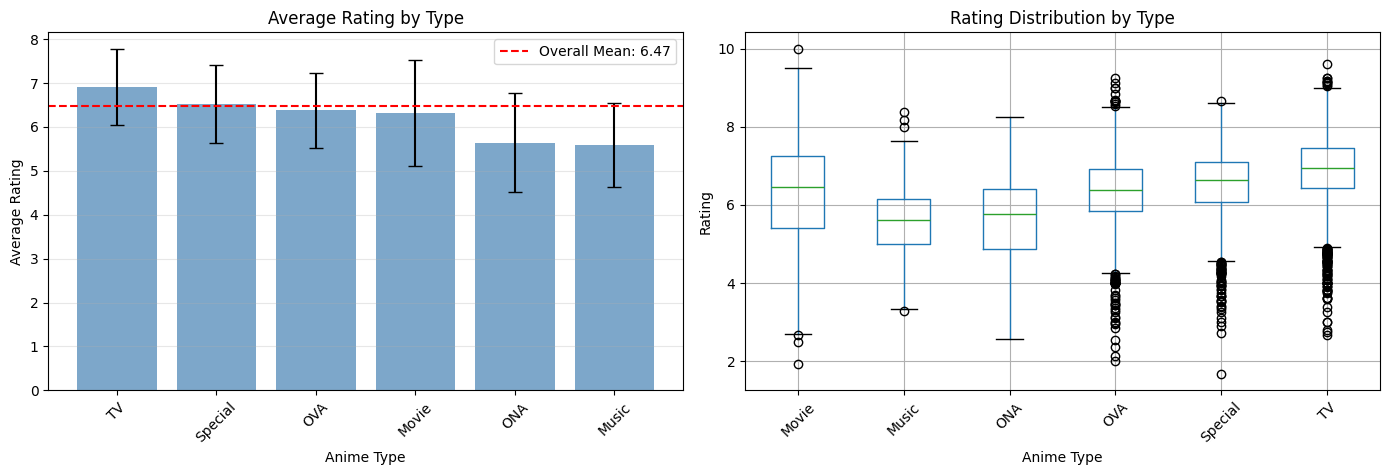

RATING BY TYPE
             mean       std  count
type                              
TV       6.902299  0.863526   3671
Special  6.523501  0.887762   1671
OVA      6.375221  0.858358   3285
Movie    6.318058  1.211988   2297
ONA      5.643298  1.127091    652
Music    5.588996  0.958440    488


In [20]:
# Rating by Type
type_rating = df_clean.groupby('type')['rating'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average rating by type
axes[0].bar(type_rating.index, type_rating['mean'], yerr=type_rating['std'], 
            color='steelblue', alpha=0.7, capsize=5)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Average Rating')
axes[0].set_title('Average Rating by Type')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(df_clean['rating'].mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {df_clean["rating"].mean():.2f}')
axes[0].legend()

# Box plot: Rating by Type
df_clean.boxplot(column='rating', by='type', ax=axes[1], grid=True)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Rating')
axes[1].set_title('Rating Distribution by Type')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()

print("="*70)
print("RATING BY TYPE")
print("="*70)
print(type_rating)


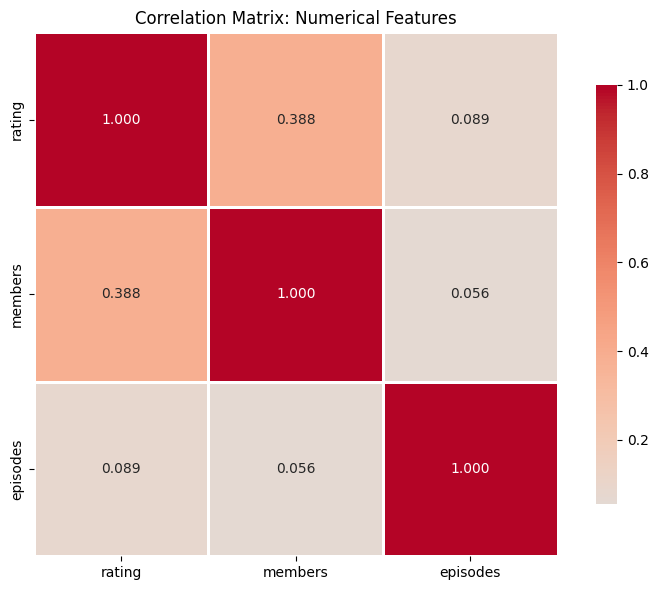

CORRELATION MATRIX
            rating   members  episodes
rating    1.000000  0.387979  0.088761
members   0.387979  1.000000  0.056056
episodes  0.088761  0.056056  1.000000


In [21]:
# Correlation matrix for numerical features
import seaborn as sns

# Select numerical columns
numeric_cols = ['rating', 'members', 'episodes']
corr_matrix = df_clean[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features')
plt.tight_layout()
plt.show()

print("="*70)
print("CORRELATION MATRIX")
print("="*70)
print(corr_matrix)


### 2.3.5 Summary Statistics Table


In [22]:
# Create summary statistics table
summary_stats = pd.DataFrame({
    'Feature': ['Rating', 'Members', 'Episodes'],
    'Mean': [df_clean['rating'].mean(), df_clean['members'].mean(), 
             df_clean['episodes'].mean()],
    'Median': [df_clean['rating'].median(), df_clean['members'].median(), 
               df_clean['episodes'].median()],
    'Std': [df_clean['rating'].std(), df_clean['members'].std(), 
            df_clean['episodes'].std()],
    'Min': [df_clean['rating'].min(), df_clean['members'].min(), 
            df_clean['episodes'].min()],
    'Max': [df_clean['rating'].max(), df_clean['members'].max(), 
            df_clean['episodes'].max()],
    'Missing': [df_clean['rating'].isnull().sum(), 
                df_clean['members'].isnull().sum(),
                df_clean['episodes'].isnull().sum()]
})

print("="*70)
print("SUMMARY STATISTICS TABLE")
print("="*70)
print(summary_stats.to_string(index=False))

# Type distribution table
print("\n" + "="*70)
print("TYPE DISTRIBUTION TABLE")
print("="*70)
type_dist = pd.DataFrame({
    'Type': df_clean['type'].value_counts().index,
    'Count': df_clean['type'].value_counts().values,
    'Percentage': (df_clean['type'].value_counts().values / len(df_clean) * 100).round(2)
})
print(type_dist.to_string(index=False))


SUMMARY STATISTICS TABLE
 Feature         Mean  Median          Std   Min       Max  Missing
  Rating     6.473902    6.57     1.026746  1.67      10.0        0
 Members 18279.524038 1539.00 55275.784229 12.00 1013917.0        0
Episodes    12.447289    2.00    47.011062  1.00    1818.0      188

TYPE DISTRIBUTION TABLE
   Type  Count  Percentage
     TV   3671       30.43
    OVA   3285       27.23
  Movie   2297       19.04
Special   1671       13.85
    ONA    652        5.40
  Music    488        4.05


## 2.4 Key Findings and Insights

### Key Observations:

1. **Rating Distribution:**
   - Mean rating: ~6.47 (out of 10)
   - Relatively normal distribution with slight skew
   - Range: 1.67 to 10.00
   - Most anime rated between 5.88 and 7.18 (IQR)

2. **Type Distribution:**
   - TV series most common (30.4%)
   - OVA second (27.2%)
   - Movie third (19.0%)
   - For binary classification: TV (61.1%) vs Movie (38.9%) - reasonably balanced

3. **Feature Relationships:**
   - Members (popularity) shows positive correlation with rating
   - Episodes may have weak relationship with rating
   - Different types have different average ratings

4. **Genre Insights:**
   - Most common genres: Action, Comedy, Drama, Romance, School
   - Many anime have multiple genres (comma-separated)
   - Need to process genre as multi-label or create binary indicators

5. **Data Quality:**
   - Clean dataset after removing missing targets
   - Episodes need conversion from string to numeric
   - Genre needs text processing for feature engineering

### Implications for Modeling:

- **Task 1 (Regression):** Rating prediction can benefit from popularity (members), type, and genre features
- **Task 2 (Classification):** Type prediction is reasonably balanced, genre and episodes may be useful features
- **Feature Engineering:** Need to process genre (split, encode), handle episodes conversion, encode type categories


---

# Section 3: Modeling

## Task 1: Regression - Rating Prediction

### Model 1: Linear Regression (Baseline)


In [31]:
# Feature engineering for baselines
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data for Task 1 (Regression)
df_task1 = df_clean[df_clean['rating'].notna()].copy()

# Prepare data for Task 2 (Binary Classification - TV vs Movie)
df_task2 = df_clean[df_clean['type'].notna()].copy()
df_task2_binary = df_task2[df_task2['type'].isin(['TV', 'Movie'])].copy()

# Simple feature engineering for baselines
# 1. Handle episodes (convert to numeric, fill missing with median)
df_task1['episodes_clean'] = pd.to_numeric(df_task1['episodes'], errors='coerce')
df_task1['episodes_clean'] = df_task1['episodes_clean'].fillna(df_task1['episodes_clean'].median())

df_task2_binary['episodes_clean'] = pd.to_numeric(df_task2_binary['episodes'], errors='coerce')
df_task2_binary['episodes_clean'] = df_task2_binary['episodes_clean'].fillna(df_task2_binary['episodes_clean'].median())

# 2. Log transform members (popularity)
df_task1['members_log'] = np.log10(df_task1['members'] + 1)
df_task2_binary['members_log'] = np.log10(df_task2_binary['members'] + 1)

# 3. Encode type (for Task 1, use as feature)
le_type = LabelEncoder()
df_task1['type_encoded'] = le_type.fit_transform(df_task1['type'].fillna('Unknown'))

# 4. Simple genre feature: count number of genres
df_task1['genre_count'] = df_task1['genre'].fillna('').str.count(',') + 1
df_task1['genre_count'] = df_task1['genre_count'].replace(0, 1)

df_task2_binary['genre_count'] = df_task2_binary['genre'].fillna('').str.count(',') + 1
df_task2_binary['genre_count'] = df_task2_binary['genre_count'].replace(0, 1)

print("Feature engineering complete!")
print(f"Task 1 samples: {len(df_task1)}")
print(f"Task 2 samples: {len(df_task2_binary)}")


Feature engineering complete!
Task 1 samples: 12064
Task 2 samples: 5968


In [32]:
# Task 1 Baseline: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Prepare features for Task 1
X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
y_task1 = df_task1['rating'].values

# Train/test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_task1, y_task1, test_size=0.2, random_state=42
)

# Train baseline model
baseline_lr = LinearRegression()
baseline_lr.fit(X_train1, y_train1)

# Predictions
y_pred_train1 = baseline_lr.predict(X_train1)
y_pred_test1 = baseline_lr.predict(X_test1)

# Evaluation
train_rmse = math.sqrt(mean_squared_error(y_train1, y_pred_train1))
test_rmse = math.sqrt(mean_squared_error(y_test1, y_pred_test1))
train_r2 = r2_score(y_train1, y_pred_train1)
test_r2 = r2_score(y_test1, y_pred_test1)
train_mae = mean_absolute_error(y_train1, y_pred_train1)
test_mae = mean_absolute_error(y_test1, y_pred_test1)

print("TASK 1: Linear Regression Baseline")
print(f"Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")


TASK 1: Linear Regression Baseline
Train RMSE: 0.7691, R²: 0.4372, MAE: 0.5693
Test RMSE: 0.7539, R²: 0.4669, MAE: 0.5693


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**Output (y):** Continuous rating (1.0-10.0)  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)²  
**Model:** Linear Regression (OLS, no regularization)

#### Discussion: Advantages and Disadvantages

**Advantages:** Simple, interpretable, fast  
**Disadvantages:** Linear assumption, no feature selection, overfitting risk  
**Complexity:** O(n×p²) training, O(p) prediction  
**Efficiency:** Very fast  
**Challenges:** Handle missing values, encode categorical features

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**No regularization or feature scaling**  
**Train/test split:** 80/20  
**Evaluation:** RMSE, R², MAE  
**Implementation:** scikit-learn's `LinearRegression` (OLS)


---

## Task 2: Binary Classification - Type Prediction (TV vs Movie)

### Model 1: Logistic Regression (Baseline)


In [ ]:
# Task 2 Baseline: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare features for Task 2
X_task2 = df_task2_binary[['episodes_clean', 'members_log', 'genre_count']].values
y_task2 = (df_task2_binary['type'] == 'Movie').astype(int).values  # 1 = Movie, 0 = TV

# Train/test split (stratified)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_task2, y_task2, test_size=0.2, random_state=42, stratify=y_task2
)

# Train baseline model (C=1.0, no penalty = no regularization)
baseline_logreg = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
baseline_logreg.fit(X_train2, y_train2)

# Predictions
y_pred_test2 = baseline_logreg.predict(X_test2)
y_proba_test2 = baseline_logreg.predict_proba(X_test2)[:, 1]

# Evaluation
test_acc = accuracy_score(y_test2, y_pred_test2)
test_prec = precision_score(y_test2, y_pred_test2)
test_rec = recall_score(y_test2, y_pred_test2)
test_f1 = f1_score(y_test2, y_pred_test2)
test_auc = roc_auc_score(y_test2, y_proba_test2)

print("TASK 2: Logistic Regression Baseline")
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")
print(f"F1: {test_f1:.4f}, ROC-AUC: {test_auc:.4f}")


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `genre_count`  
**Output (y):** Binary label (0=TV, 1=Movie)  
**Optimization:** Maximize log-likelihood (minimize cross-entropy)  
**Model:** Logistic Regression (no regularization, C=1.0)

#### Discussion: Advantages and Disadvantages

**Advantages:** Interpretable, probability estimates, fast  
**Disadvantages:** Linear decision boundary, no feature selection, overfitting risk  
**Complexity:** O(n×p×iterations) training, O(p) prediction  
**Efficiency:** Very fast  
**Challenges:** Stratified split to maintain class distribution

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `genre_count`  
**No regularization (C=1.0)**  
**Stratified train/test split:** 80/20  
**Evaluation:** Accuracy, Precision, Recall, F1, ROC-AUC  
**Implementation:** scikit-learn's `LogisticRegression` with C=1.0
